In [1]:
import obspy as ob
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from obspy.clients.fdsn import Client
os.environ["CUDA_VISIBLE_DEVICES"]= "-1"

from scripts.util import *

In [2]:
model_path = '/nas/DATA_JNU/model/bestmodel_RRU_20230217_1339.h5'
model = tf.keras.models.load_model(model_path)

In [3]:
client = Client("IRIS")

In [4]:
#Gyeongju
latitude = 35.76 
longitude = 129.19
origintime = ob.UTCDateTime("2016-09-12T11:32:54")

##Pohang
#latitude = 36.11 
#longitude = 129.37
#origintime = ob.UTCDateTime("2017-11-15T05:29:31")

#Buan
#latitude = 35.70
#longitude = 126.72
#origintime = ob.UTCDateTime("2024-06-11T23:26:49")

# Test stream 1

In [5]:
tw=30

inventory = client.get_stations(latitude=latitude,
                                network='K?',
                                 longitude=longitude,
                                 maxradius=3.0,
                                 starttime=origintime,
                                 endtime=origintime+tw)

st = ob.Stream()

for network in inventory:
    for station in network:
        net = network.code
        sta = station.code
        try:
            st_tmp = client.get_waveforms(network=net,station=sta,location='*',channel='*',starttime=origintime-30,endtime=origintime+60)
        except:
            continue
        st += st_tmp
st

18 Trace(s) in Stream:
KG.TJN..BHE  | 2016-09-12T11:32:24.019538Z - 2016-09-12T11:33:53.969538Z | 20.0 Hz, 1800 samples
KG.TJN..BHN  | 2016-09-12T11:32:24.019538Z - 2016-09-12T11:33:53.969538Z | 20.0 Hz, 1800 samples
KG.TJN..BHZ  | 2016-09-12T11:32:24.019538Z - 2016-09-12T11:33:53.969538Z | 20.0 Hz, 1800 samples
KS.BUS2..BHE | 2016-09-12T11:32:24.019500Z - 2016-09-12T11:33:53.969500Z | 20.0 Hz, 1800 samples
KS.BUS2..BHN | 2016-09-12T11:32:24.019500Z - 2016-09-12T11:33:53.969500Z | 20.0 Hz, 1800 samples
KS.BUS2..BHZ | 2016-09-12T11:32:24.019500Z - 2016-09-12T11:33:53.969500Z | 20.0 Hz, 1800 samples
KS.CHJ2..BHE | 2016-09-12T11:32:24.019500Z - 2016-09-12T11:33:53.969500Z | 20.0 Hz, 1800 samples
KS.CHJ2..BHN | 2016-09-12T11:32:24.019500Z - 2016-09-12T11:33:53.969500Z | 20.0 Hz, 1800 samples
KS.CHJ2..BHZ | 2016-09-12T11:32:24.019500Z - 2016-09-12T11:33:53.969500Z | 20.0 Hz, 1800 samples
KS.NAWB..BHE | 2016-09-12T11:32:24.019500Z - 2016-09-12T11:33:53.969500Z | 20.0 Hz, 1800 samples
KS.NAWB

# Test stream 2

In [6]:
st = client.get_waveforms(network='IU',station='INCN',location='10',channel='HH?',starttime=origintime-30,endtime=origintime+150)
st

3 Trace(s) in Stream:
IU.INCN.10.HH1 | 2016-09-12T11:32:34.628394Z - 2016-09-12T11:35:23.998394Z | 100.0 Hz, 16938 samples
IU.INCN.10.HH2 | 2016-09-12T11:32:34.908394Z - 2016-09-12T11:35:23.998394Z | 100.0 Hz, 16910 samples
IU.INCN.10.HHZ | 2016-09-12T11:32:33.648393Z - 2016-09-12T11:35:23.998393Z | 100.0 Hz, 17036 samples

# Test stream 3

In [7]:
st = ob.read('/home/kgunwoo1/seismic/buan_100sps_100km/*')
st

222 Trace(s) in Stream:

KS.AMD..HGE | 2024-06-11T23:26:43.998397Z - 2024-06-11T23:31:48.998397Z | 100.0 Hz, 30501 samples
...
(220 other traces)
...
KS.YUGA..HGZ | 2024-06-11T23:26:44.003095Z - 2024-06-11T23:31:49.003095Z | 100.0 Hz, 30501 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

# Test stream 4

In [8]:
st = ob.read()
st

3 Trace(s) in Stream:
BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHN | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples
BW.RJOB..EHE | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples

In [9]:
scnl_df = get_scnl(st)
scnl_df

,network,station,channel
0,BW,RJOB,EH


In [10]:
Y_total =[]
data_total = []
startT_total = []

for idx, row in scnl_df.iterrows():
    print(f'{row.network}.{row.station}..{row.channel}')
    data, Y_med, startT = picking(row.network, row.station, row.channel, st.copy(), twin=3000, stride=3000, model=model)
    data_total.append(data)
    Y_total.append(Y_med)
    startT_total.append(startT)
data_total = np.stack(data_total, axis=0)  
Y_total = np.stack(Y_total, axis=0)
scnl_df['start_time'] = startT_total

BW.RJOB..EH


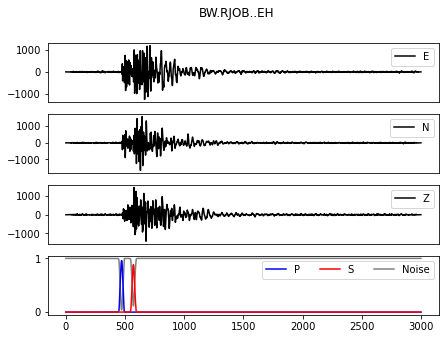

In [11]:
for idx, row in scnl_df.iterrows():
    plot_results(row.network, row.station, row.channel, data_total[idx], Y_total[idx])

In [12]:
picks_total = pd.DataFrame()
for idx, row in scnl_df.iterrows():
    arr_lst = get_picks(Y_total[idx], row.network, row.station, row.channel, row.start_time)
    picks = pd.DataFrame(arr_lst, columns=['network','station','channel','arr','prob','phase'])
    picks_total = pd.concat([picks_total, picks])
picks_total.sort_values(by=['arr'], inplace=True)

picks_total

,network,station,channel,arr,prob,phase
0,BW,RJOB,EH,2009-08-24T00:20:07.710000Z,0.958617,P
1,BW,RJOB,EH,2009-08-24T00:20:08.710000Z,0.882560,S
